In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# import dataset
df = pd.read_csv('time_series_dataframe.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# convert date column into datetime
df.date = pd.to_datetime(df.date)

# set date column to index
df.set_index('date', inplace=True)

### EDA

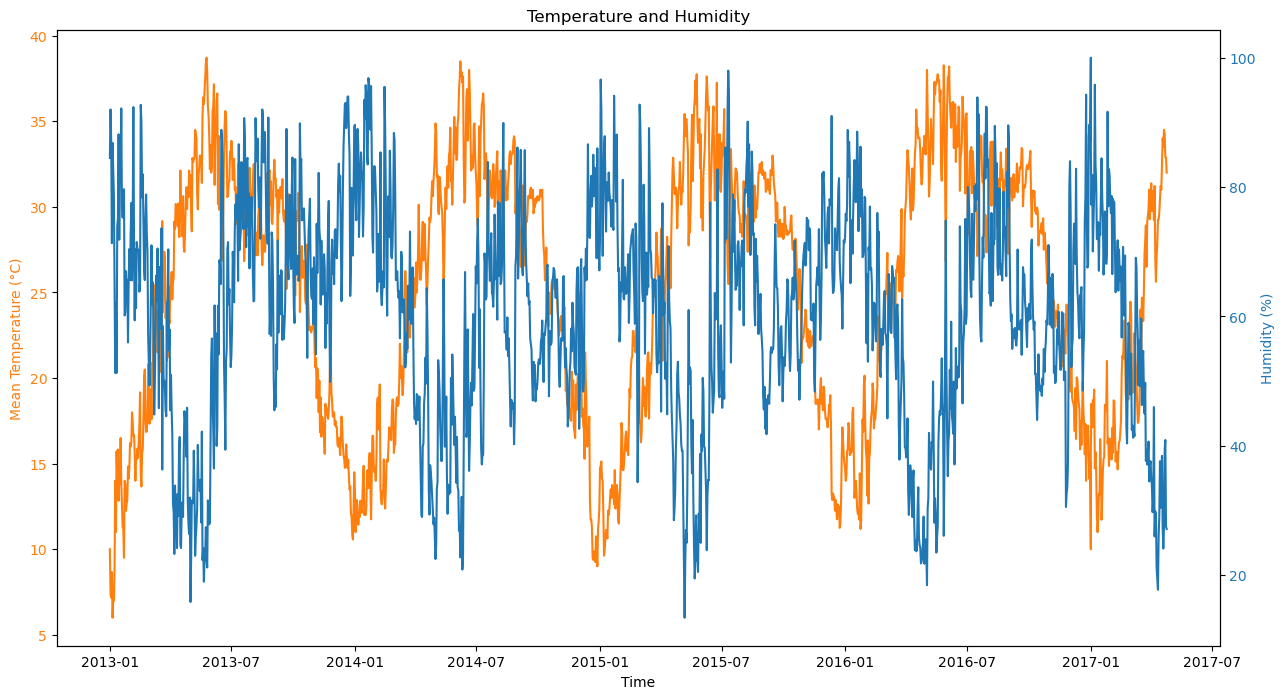

In [5]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot the first y-axis (meantemp)
color = 'tab:orange'
ax1.set_xlabel('Time')
ax1.set_ylabel('Mean Temperature (°C)', color=color)
ax1.plot(df['meantemp'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Humidity (%)', color=color)
ax2.plot(df['humidity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Temperature and Humidity')
plt.show()

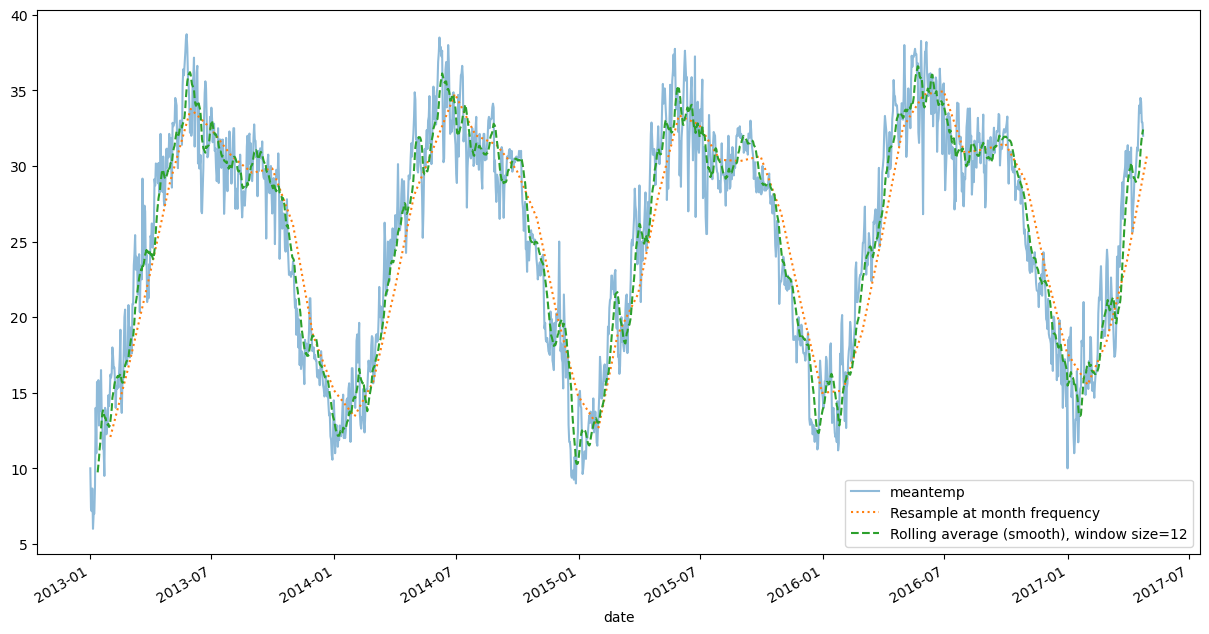

In [6]:
## smooth temperature

temperature = df.meantemp
temp_resamp_month = temperature.resample('M').mean()
temp_roll_yr = temperature.rolling(12).mean()

fig, ax = plt.subplots(figsize=(15, 8))
ax = temperature.plot(alpha=0.5, style='-') # store axis (ax) for latter plots
temp_resamp_month.plot(style=':', label='Resample at month frequency', ax=ax)
temp_roll_yr.plot(style='--', label='Rolling average (smooth), window size=12', ax=ax)
ax.legend()

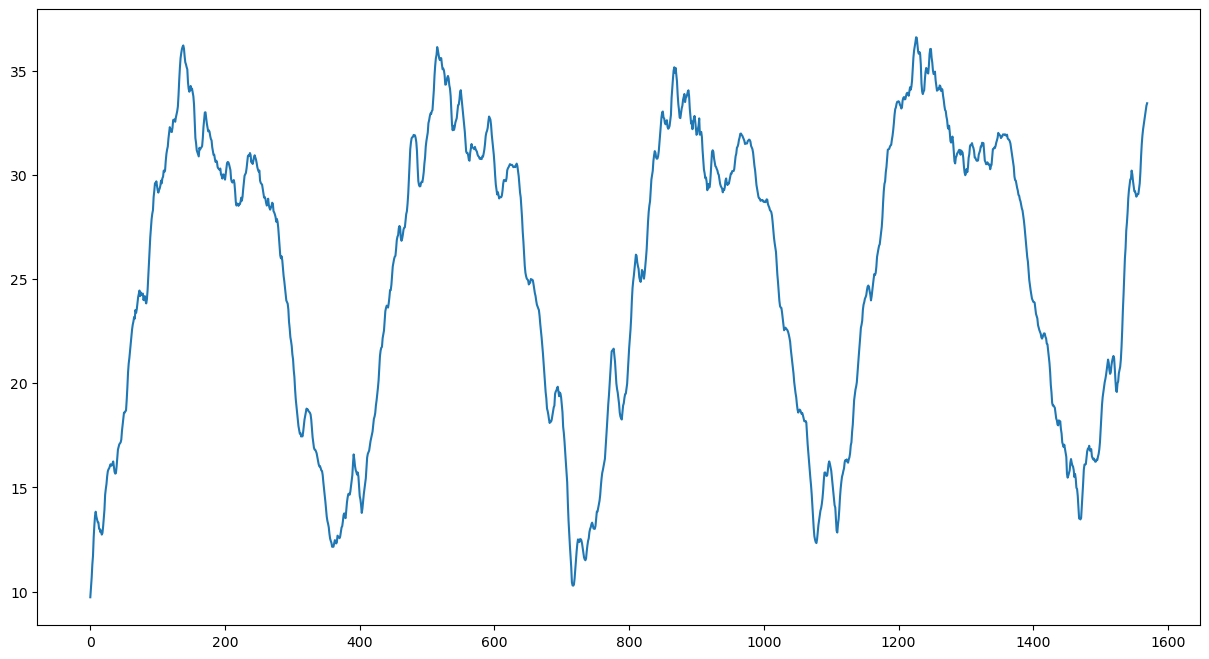

In [7]:
# Alternative smoothing technique with numpy

fig, ax = plt.subplots(figsize=(15, 8))

x = np.asarray(df[['meantemp']])
win = 12
win_half = int(win / 2)
t_smooth = np.array([x[(idx-win_half):(idx+win_half)].mean() for idx in np.arange(win_half, len(x))])
plt.plot(t_smooth)

Text(0.5, 0, 'Year')

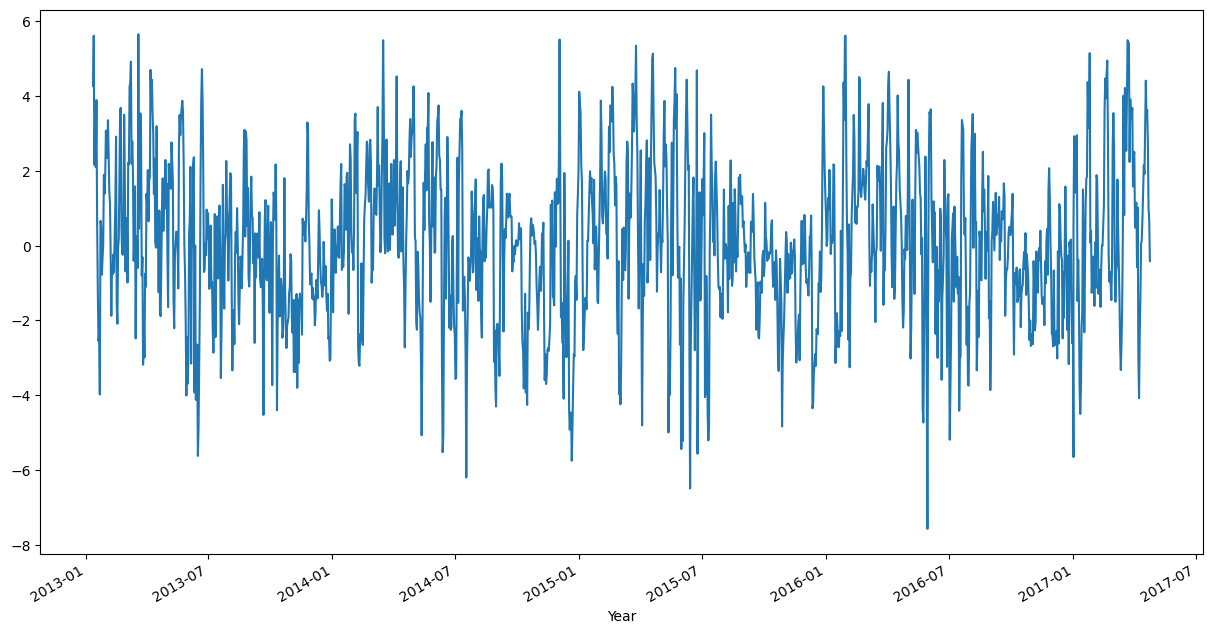

In [8]:
# Detrending
temp_df = df.copy()
temperature = df.meantemp
temp_df = temp_df[['meantemp']]
temp_df['smooth_temp'] = temperature.rolling(12).mean()

fig, ax = plt.subplots(figsize=(15, 8))

d_trend = temp_df['meantemp'] - temp_df['smooth_temp']
d_trend.plot()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

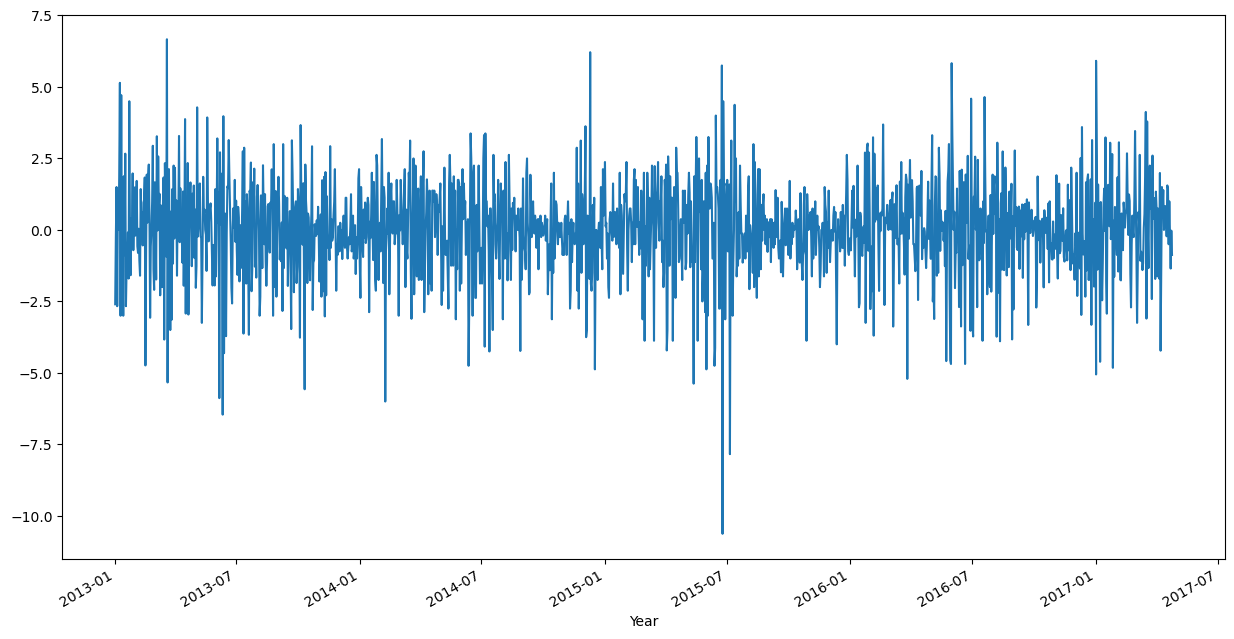

In [9]:
# First-Order differencing
fig, ax = plt.subplots(figsize=(15, 8))

df.meantemp.diff().plot()
plt.xlabel('Year')

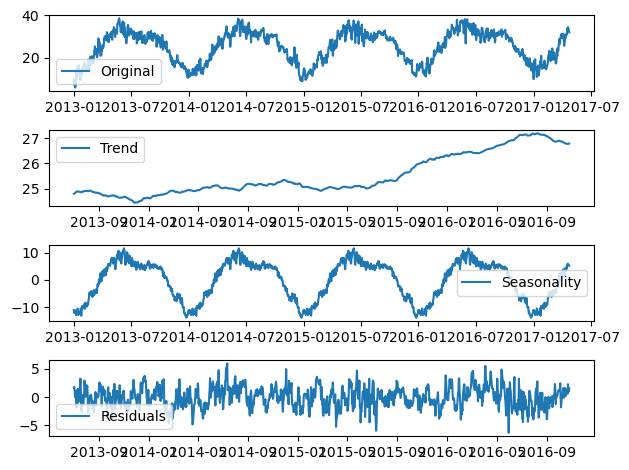

In [10]:
# Decomposing a time series - Yearly
from statsmodels.tsa.seasonal import seasonal_decompose 

x = df.meantemp

x = x.astype(float) # force float
decomposition = seasonal_decompose(x, period = 365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

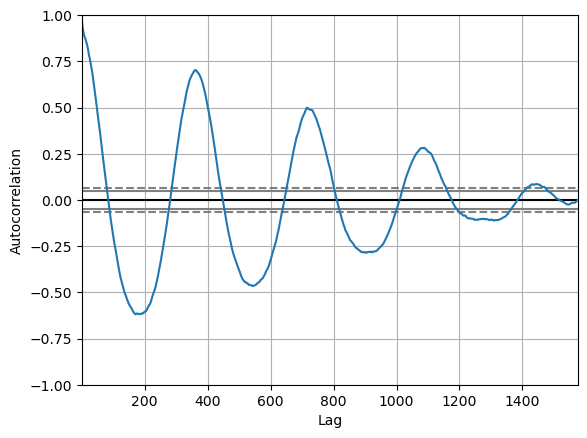

In [11]:
# Autocorrelation 

from pandas.plotting import autocorrelation_plot

x = df.meantemp

autocorrelation_plot(x)

Text(0.5, 1.0, 'Autocorrelation Function')

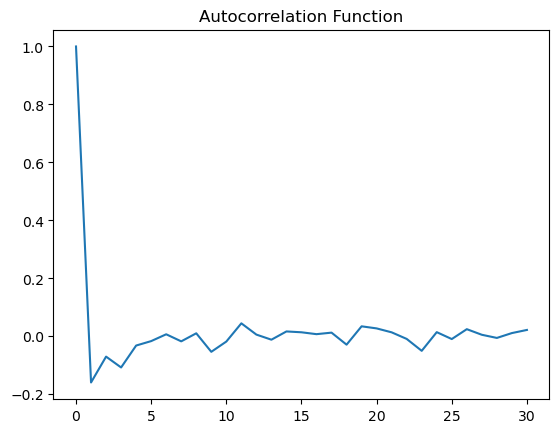

In [12]:
# Compute autocorrelation function 
from statsmodels.tsa.stattools import acf
x_diff = x.diff().dropna() # first item is NA
lag_acf = acf(x_diff, nlags=30)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')

In [21]:
# Determining if data is Stationary with augmented Dickey-Fuller test (to determine the d value of arima)
from statsmodels.tsa.stattools import adfuller
# Assuming 'temperature' is your time series data
temperature = df['meantemp'].astype(float)

# Perform ADF test
result = adfuller(temperature)

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print('The time series is likely stationary (reject the null hypothesis)')
else:
    print('The time series is likely non-stationary (fail to reject the null hypothesis)')


ADF Statistic: -2.3791899484520904
P-value: 0.14769623489792422
The time series is likely non-stationary (fail to reject the null hypothesis)


In [22]:
# Try to make data stationary 
# Assuming 'temperature' is your time series data
df['temperature_diff'] = df['meantemp'].diff()

# Drop the first row (NaN due to differencing)
df = df.dropna()

diff_temperature = df['temperature_diff'].astype(float)

# Perform ADF test
result = adfuller(diff_temperature)

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print('The time series is likely stationary (reject the null hypothesis)')
else:
    print('The time series is likely non-stationary (fail to reject the null hypothesis)')

ADF Statistic: -16.9089877649874
P-value: 1.014093812317219e-29
The time series is likely stationary (reject the null hypothesis)


In [24]:
# Number of differences to perform
order_of_differences = 2

# Perform differencing
for i in range(order_of_differences):
    df['temperature_diff'] = df['temperature_diff'].diff()

df.dropna(inplace=True)
diff_temperature = df['temperature_diff'].astype(float)

# Perform ADF test
result = adfuller(diff_temperature)

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Check the p-value against a significance level (e.g., 0.05)
if p_value <= 0.05:
    print('The time series is likely stationary (reject the null hypothesis)')
else:
    print('The time series is likely non-stationary (fail to reject the null hypothesis)')

ADF Statistic: -24.11561289373908
P-value: 0.0
The time series is likely stationary (reject the null hypothesis)


<Figure size 1200x600 with 0 Axes>

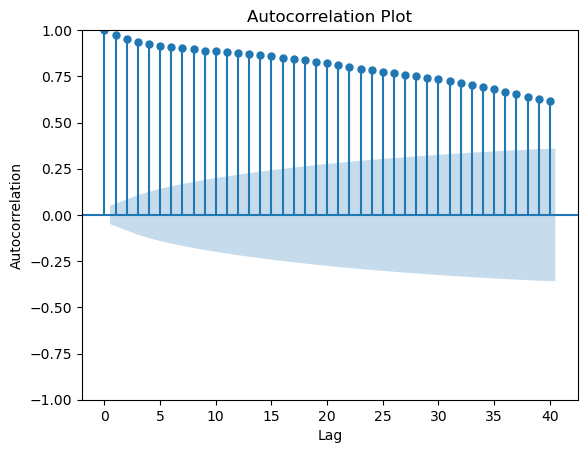

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Assuming 'temperature' is your time series data
df['temperature'] = df['meantemp'].astype(float)

# Plot the autocorrelation function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(df['temperature'], lags=40, alpha=0.05)
plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

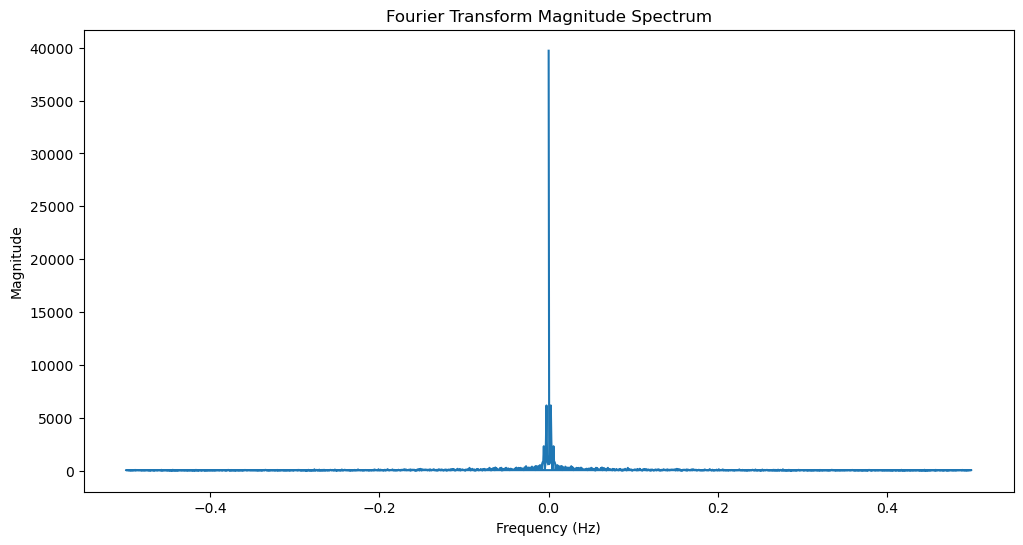

In [26]:
# Forier Transform - INCOMPLETE

# Assuming 'temperature' is your time series data
temperature = df['meantemp'].astype(float)

# Number of data points
n = len(temperature)

# Sample spacing (assuming uniform sampling, adjust if needed)
dt = 1.0

# Perform Fourier transform
freq = np.fft.fftfreq(n, dt)
fft_values = np.fft.fft(temperature)
magnitude_spectrum = np.abs(fft_values)

# Plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.plot(freq, magnitude_spectrum)
plt.title('Fourier Transform Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

### Forecasting using ARIMA

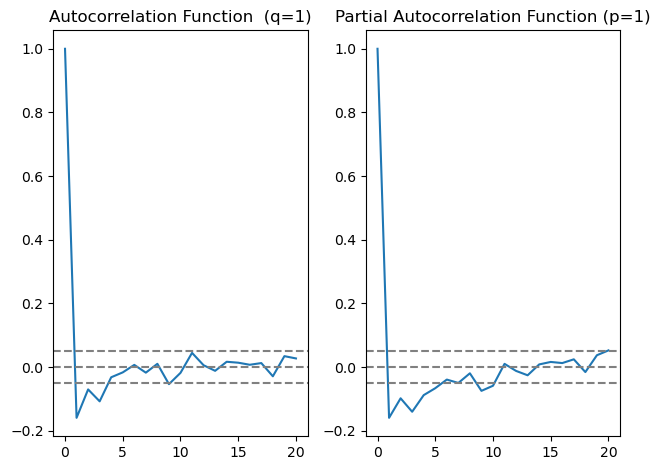

In [13]:
from statsmodels.tsa.stattools import acf, pacf

x = df["meantemp"].astype(float)
x_diff = x.diff().dropna() # first item is NA
# ACF and PACF plots:
lag_acf = acf(x_diff, nlags=20)
lag_pacf = pacf(x_diff, nlags=20, method='ols')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function  (q=1)')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function (p=1)')
plt.tight_layout()

/Users/gianlucascibilia/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gianlucascibilia/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gianlucascibilia/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1576
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2993.895
Date:                Sun, 24 Dec 2023   AIC                           5993.790
Time:                        07:17:52   BIC                           6009.876
Sample:                             0   HQIC                          5999.768
                               - 1576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5854      0.045     13.053      0.000       0.498       0.673
ma.L1         -0.8066      0.035    -22.898      0.000      -0.876      -0.738
sigma2         2.6216      0.071     36.762      0.0

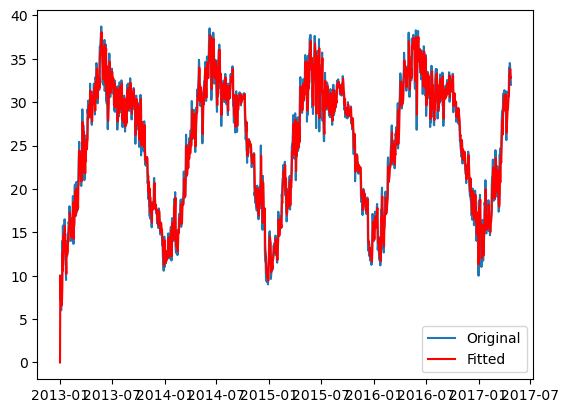

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model
model = ARIMA(x, order=(1, 1, 1)).fit()

# Display model summary
print(model.summary())

from sklearn.metrics import mean_squared_error
import numpy as np

predictions = model.predict()
rmse = np.sqrt(mean_squared_error(x, predictions))
print('RMSE: ', rmse)

# Plot the time series and the fitted values
plt.plot(x, label='Original')
plt.plot(model.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.show()